In [1]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model
from sklearn.metrics import classification_report

In [2]:
tf.random.set_seed(42)
np.random.seed(1337)

In [3]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip folder and define data directory.
data_source = "/content/drive/MyDrive/Data_Visualization/Project/Data/Covid_Dataset.rar"
data_output = "/content"
!unrar x -Y $data_source $data_output

Streaming output truncated to the last 5000 lines.
Extracting  /content/Covid_Dataset/train/Normal/Normal_1077.png           50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10770.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10771.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10772.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10773.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10774.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10775.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10776.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10778.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10781.png          50%  OK 
Extracting  /content/Covid_Da

In [5]:
#Define the hyper parameters
data_dir = '/content/Covid_Dataset'
classes = ['COVID', 'Normal']
initial_epochs = 50
initial_LR = 0.0001
dropout =.5
batch_size =64
configuration = 'VGG16_'+str(initial_LR)+'_WD_'+str(dropout)+'_'+str(batch_size)+'_V4'

In [6]:
! mkdir $configuration

In [7]:
#Define the data paths
train_path = data_dir + '//train'
valid_path = data_dir + '//valid'
test_path = data_dir + '//test'

In [8]:
#Define batches and use the preprocessing function of VGG16
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=train_path, classes=classes, target_size=(224, 224), batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=valid_path, classes=classes, target_size=(224, 224), batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_path, classes=classes, target_size=(224, 224), batch_size=batch_size, shuffle=False)

Found 8500 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


In [9]:
#Define input shape and use the weights from Imagenet and the network is a VGG16
INPUT_SHAPE = (224,224,3)
base_model = VGG16(input_shape= INPUT_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True

58889256/58889256 [==============================] - 2s 0us/step


In [10]:
for layer in base_model.layers:
  if('block1' in layer.name or 'block2' in layer.name):
    layer.trainable = False
  else:
    continue

In [11]:
#Define the model
x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
outputs = Dense(2, activation='sigmoid')(x)

In [12]:
model = keras.Model(inputs = base_model.input, outputs = outputs, name='VGG_16')

In [13]:
#Prints a summary of the network.
model.summary()

Model: "VGG_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0    

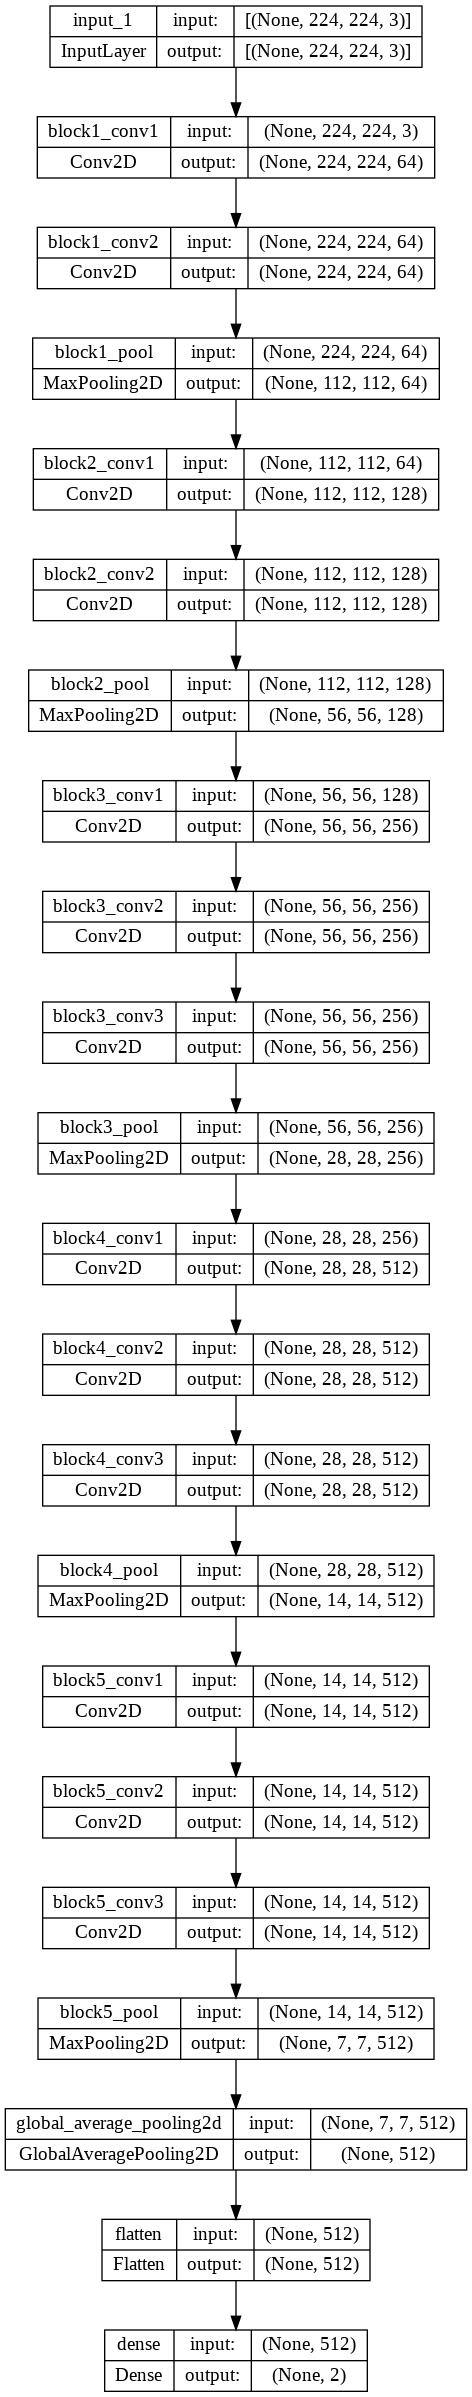

In [14]:
#Plot the model
tf.keras.utils.plot_model(model, to_file= '/content/'+configuration+'/'+configuration+'_MODEL.png', show_shapes=True, show_layer_names=True)

In [15]:
#Stop training when a monitored metric has stopped improving
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

#Callback to save the Keras model or model weights at some frequency.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/'+configuration+'/'+configuration+'.h5', monitor='val_loss', save_best_only=True, mode='min')

#Configures the model for training
model.compile(optimizer=Adam(learning_rate=initial_LR, decay=initial_LR / initial_epochs), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
#Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(
      train_batches,
      epochs = initial_epochs,
      validation_data=valid_batches,
      verbose=1,
      callbacks = [earlystopping_callback,checkpoint_callback]
    )

Epoch 1/50
133/133 [==============================] - 102s 648ms/step - loss: 0.3632 - accuracy: 0.8596 - val_loss: 0.1320 - val_accuracy: 0.9450
Epoch 2/50
133/133 [==============================] - 81s 609ms/step - loss: 0.1155 - accuracy: 0.9618 - val_loss: 0.0895 - val_accuracy: 0.9725
Epoch 3/50
133/133 [==============================] - 81s 609ms/step - loss: 0.0675 - accuracy: 0.9781 - val_loss: 0.0425 - val_accuracy: 0.9825
Epoch 4/50
133/133 [==============================] - 81s 607ms/step - loss: 0.0525 - accuracy: 0.9826 - val_loss: 0.0507 - val_accuracy: 0.9825
Epoch 5/50
133/133 [==============================] - 81s 606ms/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.0795 - val_accuracy: 0.9725
Epoch 6/50
133/133 [==============================] - 81s 610ms/step - loss: 0.0238 - accuracy: 0.9929 - val_loss: 0.0325 - val_accuracy: 0.9925
Epoch 7/50
133/133 [==============================] - 81s 607ms/step - loss: 0.0128 - accuracy: 0.9952 - val_loss: 0.0456 - val_a

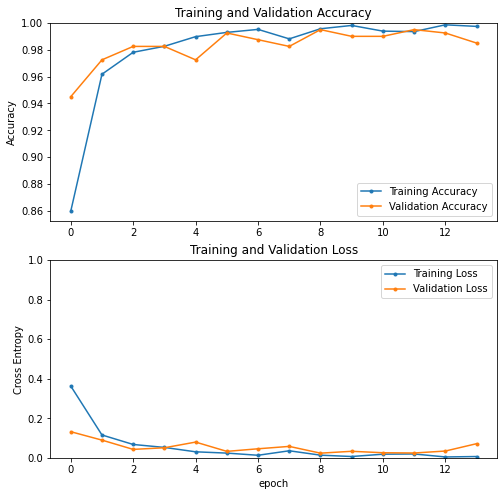

In [17]:
# Plot (training and validation) accuracy and loss figures respectively
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker = '.')
plt.plot(val_acc, label='Validation Accuracy', marker = '.')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker = '.')
plt.plot(val_loss, label='Validation Loss', marker = '.')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/'+configuration+'/'+configuration+'_CURVE.png')
plt.show()

In [18]:
ran_epochs = len(history.history['accuracy'])
best_epoch = 0
if(ran_epochs != 50):
  if(ran_epochs > 5):
    best_epoch = ran_epochs - 6  
  else:
    best_epoch = 0
else:
  best_epoch = 49

In [19]:
train_accuracy = history.history['accuracy'][best_epoch]
train_loss = history.history['loss'][best_epoch]
train_accuracy = round(train_accuracy * 100,2)
train_loss = round(train_loss,2)
print(f'Training Accuracy: {train_accuracy}%')
print(f'Training Loss: {train_loss}')

Training Accuracy: 99.56%
Training Loss: 0.01


In [20]:
valid_accuracy = history.history['val_accuracy'][best_epoch]
valid_loss = history.history['val_loss'][best_epoch]
valid_accuracy = round(valid_accuracy * 100,2)
valid_loss = round(valid_loss,2)
print(f'Validation Accuracy: {valid_accuracy}%')
print(f'Validation Loss: {valid_loss}')

Validation Accuracy: 99.5%
Validation Loss: 0.02


In [21]:
#Returns the loss value & metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(test_batches)
test_accuracy = round(test_accuracy * 100,2)
test_loss = round(test_loss,2)
print(f'Testing Accuracy: {test_accuracy}%')
print(f'Testing Loss: {test_loss}')

20/20 [==============================] - 10s 496ms/step - loss: 0.0375 - accuracy: 0.9888
Testing Accuracy: 98.88%
Testing Loss: 0.04


In [22]:
#Print the results in a dataframe 
results = {'Training Accuracy': train_accuracy, 'Training Loss':train_loss,
           'Validation Accuracy':valid_accuracy,'Validation Loss':valid_loss,
           'Testing Accuracy':test_accuracy,'Testing Loss':test_loss}
results_df = pd.DataFrame(results, index = [configuration])
results_df = results_df.round(2)
results_df.to_csv('/content/'+configuration+'/'+configuration+'_RESULTS.csv')
results_df

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Testing Accuracy,Testing Loss
VGG16_0.0001_WD_0.5_64_V4,99.56,0.01,99.5,0.02,98.88,0.04


In [23]:
#Generates output predictions for the input samples.
predictions = model.predict(x=test_batches, verbose = 1)

20/20 [==============================] - 6s 310ms/step


In [24]:
#Print a classification report
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=classes, output_dict=True)
df = pd.DataFrame(cr).transpose()
df = df.round(2)
df.to_csv('/content/'+configuration+'/'+configuration+'_CR.csv')
print(df)

              precision  recall  f1-score  support
COVID              0.99    0.99      0.99   626.00
Normal             0.99    0.99      0.99   626.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.99    0.99      0.99  1252.00
weighted avg       0.99    0.99      0.99  1252.00


In [25]:
#Define a function to use in plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/'+configuration+'/'+configuration+'_CM.png')

Confusion matrix, without normalization


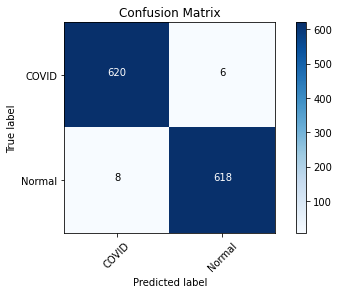

In [26]:
#Plot the confusion matrix 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

In [27]:
! cp -r "/content/"$configuration "/content/drive/MyDrive/Data_Visualization/Project/Networks"